# Import libraries

In [1]:
import util
import numpy as np
import cv2
import matplotlib.pyplot as plt
import stepic
from PIL import Image, ImageOps

# Loading images

In [15]:
img_kyoto = cv2.cvtColor(cv2.imread("../images/kyoto-2.bmp"), cv2.COLOR_BGR2GRAY)
img_kyoto.shape

(300, 400)

In [ ]:
img_kyoto = Image.open('../images/kyoto-2.bmp')
img_kyoto.size

In [ ]:
plt.imshow(img_kyoto, cmap = 'gray')
plt.title("Original kyoto image")
plt.show()

# Define mask

In [2]:
np_mask = np.array([[1, 0], [0, 1]])

# Small matrix test

In [6]:
img_example = np.random.randint(0, high = 256, size = 48).reshape(4, 4, 3)
img_example

array([[[176, 209, 183],
        [223, 220, 229],
        [228,  10, 189],
        [104, 181,  95]],

       [[227,  53, 157],
        [120,  13, 147],
        [156, 248,  18],
        [153, 210,  19]],

       [[ 34,  76,  97],
        [ 41,  48, 171],
        [ 47,  63, 168],
        [ 37, 106, 115]],

       [[  2,  42,  11],
        [ 85, 135,  97],
        [130, 250, 191],
        [ 52,  14, 201]]])

(4, 4)


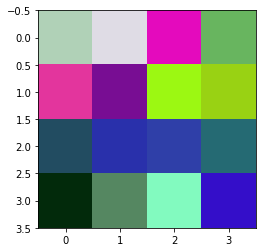

In [9]:
pillowExample = Image.fromarray(img_example.astype('uint8'), 'RGB')

print(pillowExample.size)

plt.imshow(np.asarray(pillowExample))
plt.show()

In [7]:
print ( util.calculate_count_groups(img_example, -np_mask) )

(0.75, 0.25)


In [8]:
print ( util.calculate_count_groups(img_example, np_mask) )

(0.25, 0.75)


In [10]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [11]:
# msg_stego = "sparklingPhotons"      # Data is too large! O_O
msg_stego = "spark"  # bigger than this --> ValueError

for i in range(4):
    img_encoded = stepic.encode(pillowExample, msg_stego[:4*(i+1)].encode('utf-8'))
    np_img_encoded = np.array(img_encoded)
    temp1, temp2 = util.calculate_count_groups(np_img_encoded, np_mask)
    r_m.append(temp1); s_m.append(temp2)
    temp1, temp2 = util.calculate_count_groups(np_img_encoded, -np_mask)
    r_neg_m.append(temp1); s_neg_m.append(temp2)

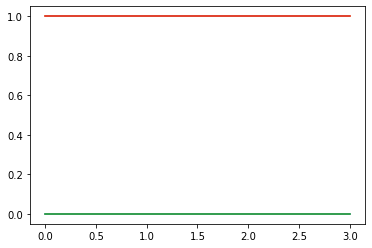

In [12]:
plt.plot(range(len(r_m)), r_m)
plt.plot(range(len(s_m)), s_m)
plt.plot(range(len(r_neg_m)), r_neg_m)
plt.plot(range(len(s_neg_m)), s_neg_m)

# Experimentation - Stepic

In [ ]:
msg_stego = "photons awesome"*1000
len(msg_stego)

In [ ]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [ ]:
print(util.calculate_count_groups(img_kyoto, -np_mask))
print(util.calculate_count_groups(img_kyoto, np_mask))

In [ ]:
for i in range(100):
    img_encoded = stepic.encode(img_kyoto, msg_stego[:150*(i+1)].encode('utf-8'))
    np_img_encoded = np.array(img_encoded)
    # print(np_img_encoded.shape)
    temp1, temp2 = util.calculate_count_groups(np_img_encoded, np_mask)
    r_m.append(temp1); s_m.append(temp2)
    temp1, temp2 = util.calculate_count_groups(np_img_encoded, -np_mask)
    r_neg_m.append(temp1); s_neg_m.append(temp2)

In [ ]:
plt.plot(range(len(r_m)), r_m)
plt.plot(range(len(s_m)), s_m)
plt.plot(range(len(r_neg_m)), r_neg_m)
plt.plot(range(len(s_neg_m)), s_neg_m)

# Testing S-Tools

Note: The passphrase for every stego-image is the name of the image (without file extension)

In [ ]:
messageFile = open("secretMessage2.txt", "w")
msgString = util.randomString(70000)
messageFile.write(msgString)
messageFile.close()

In [ ]:
hiddenKyoto1 = cv2.imread("../images/kyoto-2_hidden.bmp")    # This one has about 25000 bytes hidden
hiddenKyoto2 = cv2.imread("../images/kyoto-2_hidden2.bmp")      # This one nearly fills up the full capacity
hiddenKyoto3 = cv2.imread("../images/kyoto-2_hidden3.bmp")
hiddenKyoto4 = cv2.imread("../images/kyoto-2_hidden4.bmp")
hiddenKyoto5 = cv2.imread("../images/kyoto-2_hidden5.bmp")

In [ ]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [ ]:
fileNames = [hiddenKyoto1, hiddenKyoto2, hiddenKyoto3, hiddenKyoto4, hiddenKyoto5]

for i in range(5):
    temp1, temp2 = util.calculate_count_groups(fileNames[i], np_mask)
    r_m.append(temp1); s_m.append(temp2)
    temp1, temp2 = util.calculate_count_groups(fileNames[i], -np_mask)
    r_neg_m.append(temp1); s_neg_m.append(temp2)

In [ ]:
plt.plot(range(len(r_m)), r_m)
plt.plot(range(len(s_m)), s_m)
plt.plot(range(len(r_neg_m)), r_neg_m)
plt.plot(range(len(s_neg_m)), s_neg_m)

# Flipping LSBs instead of hiding messages

In [13]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []

In [16]:
for i in range(100):
    flippedLSBs = util.simpleLSBFlipper(img_kyoto, 3600*(i+1))
    temp1, temp2 = util.calculate_count_groups(flippedLSBs, np_mask)
    r_m.append(temp1); s_m.append(temp2)
    temp1, temp2 = util.calculate_count_groups(flippedLSBs, -np_mask)
    r_neg_m.append(temp1); s_neg_m.append(temp2)

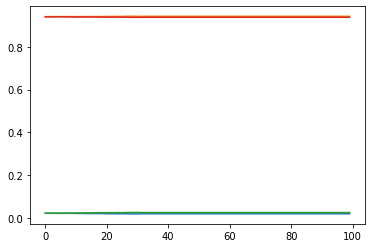

In [17]:
plt.plot(range(len(r_m)), r_m)
plt.plot(range(len(s_m)), s_m)
plt.plot(range(len(r_neg_m)), r_neg_m)
plt.plot(range(len(s_neg_m)), s_neg_m)